In [1]:
#import Pkg; Pkg.add("FFT")
using Polynomials,  SpecialPolynomials, Plots
using PyCall
#using AbstractFFTs
using FFTW
using LinearAlgebra

In [2]:
psrchive = pyimport("psrchive")

@kwdef mutable struct Arch
    name::String
    dm::Float64
    period::Float64
    nbin::Int64
    nchan::Int64
    data::Array
    noise::Array
    freq::Array
    reffreq::Float64
    wts::Array

    inc_τ::Bool = true
    inc_α::Bool = false
    inc_EFAC::Bool = true

    Nsamp::Int64 # Number of Shapelet amplitudes
    
end

Arch

In [4]:
function PBF(f, τ, ν, α)
    """
    Pulse broadening function in Fourier domain(f, τ, ν, α):
        Return the Fourier pulse broadening function given by Lentati et al.2017:
             - f: Fourier frequencies
             - τ: the scattering time scale
             - ν: the observing frequency
             - α: the scattering index
    """
    twopifnu = 2*π*f*ν * α*10^τ
    return 1 ./(twopifnu.^2 .+ 1) + 1im*(-twopifnu)./(twopifnu.^2 .+ 1)
end

PBF (generic function with 1 method)

In [5]:


function rotate(fftprofile, ϕ)
    """                                                                         
    rotate(fftprofile, ϕ):                                                      
        Return array 'fftprofile' rotated by ϕ to the left.  The           
                rotation is done using the Shift Theorem assuming
                the profile is in freq domain. ϕ is fractional 
                between 0 and 1.  The resulting vector will have           
                the same length as the original.                                    
    """
    f = collect(0:length(fftprofile)-1)
    return fftprofile .* exp.(2im*π * f * ϕ)
end

function shapelet_model(Shap_amp, period, nbin, β)

    pulse_model = zeros(nbin)
    
    nu = collect(0:nbin-1) / nbin * period .- period/2.
    nw = nu * β.^(-1)
    #println(nw)

    x = variable(Polynomial{Rational{Int}})
    H=[basis(Hermite, i)(x) for i in 0:length(Shap_amp)]
    
    # First Shapelet component has a fixed amplitude of 1
    n = 0
    pulse_model += @. Complex(1 * β^-.5 * (2^n * factorial(n) * π^.5)^-.5 * H[n+1].(nw)) .* exp.(-0.5 * nw.*nw)

    #println(ar.Nsamp)
    for n in 1:ar.Nsamp
        pulse_model += @. Complex(Shap_amp[n] * Complex(β)^-.5 * Complex(2^n * factorial(n) * π^.5)^-.5 * H[n+1].(nw)) .* exp.(-0.5 * nw.*nw)
    end
    return pulse_model
end
    

function load_data(filename, nchan, inc_τ, inc_α, inc_EFAC, Nsamp)
    ar = psrchive.Archive_load(filename)
    ar.tscrunch()
    ar.pscrunch()
    ar.fscrunch_to_nchan(nchan)
    ar.remove_baseline()
    ar.bscrunch(2)
    #ar.dedisperse()
    dm = ar.get_dispersion_measure()
    nbin = ar.get_nbin()
    reffreq = ar.get_centre_frequency()

    
    # Get the profile data
    data = transpose(ar.get_data()[1,1,:,:])
    #print(size(data_tmp))
    #data = Array{Float64}(vec(transpose(ar.get_data()[1,1,:,:])))
    #print(size(data))
    #println(findmax(data, 1))

    # Get Folding period
    integ = ar.get_first_Integration()
    period = integ.get_folding_period()

    # Get channel frequencies
    freqs = ar.get_frequencies()/1000.

    # Get weights
    wts = ar.get_weights()

    
    #if iszero(ar.wts[ichan])
    #     continue
    #end
    maxs = maximum(data, dims=1)
    data = data ./ maxs
    noise = sqrt.(integ.baseline_stats()[2]) ./ maxs 
    #println(noise[2])

    #println(sqrt.(integ.baseline_stats()[2]))
    ## Get baseline RMS (1) for total intensity (0)
    #    stats = np.sqrt((integ.baseline_stats()[1][0])/maximums)
    #    stats = np.where(stats==0, 1., stats)

    arch = Arch(filename, dm, period, nbin, nchan, data, noise, freqs, reffreq, wts, inc_τ, inc_α, inc_EFAC, Nsamp)
    return arch
end



load_data (generic function with 1 method)

In [12]:
function likelihood(cube)
    ipar = 1
    βs = cube[:, ipar] ; ipar += 1 # Shapelet width scale factor
    nlive = length(βs) # Number of live points 
    ϕ0s = cube[:, ipar]; ipar += 1 # Phase of the pulse at ...  
    Samp = cube[:,ipar:ipar + ar.Nsamp-1]; ipar += ar.Nsamp # Shapelet amplitude
    
    # include DM if more than one frequency channel in the model
    if ar.nchan > 1
        DMs = cube[:,ipar]; ipar += 1
    else
        DMs = ones(nlive) * ar.DM
    end

    # Scattering time scale at XXX
    if ar.inc_τ
        τs = cube[:,ipar]; ipar += 1
    end
    
    # Scattering index 
    if ar.nchan > 1 && ar.inc_τ && ar.inc_α
        αs = cube[:,ipar]; ipar += 1
    else
        αs = ones(nlive) * -3.8
    end

    # EFAC, not implemented yet
    if ar.inc_EFAC 
        EFAC = cube[:,ipar]; ipar +=1
    else
        EFAC = 1
    end

    # Compute the Noise vector - SHOULD BE MOVED OUT OF LIKELIHOOD
    N = ones(ar.nchan * ar.nbin)
    for i in 1:ar.nchan
        for j in 1:ar.nbin
            N[j+(i-1)*ar.nbin] *= ar.noise[i] * EFAC
        end
    end
    N = Diagonal(N)
    Ni = Diagonal(1 ./N)  # Diagonal matrix of the inverted noise vector, size Nchan * Nbin
    detN = -tr(log(Ni))

    F = zeros(ar.nchan * ar.nbin, 2*ar.nchan)
    Vec1 = ones(ar.nbin)
    data = ar.data

    #model = shapelet_model(Samp, ar.period, ar.nbin, β) 
    #fftmodel = rfft(model)

    fftmodel_freqs = collect(0:ar.nbin/ 2) / ( ar.period)

    L = zeros(nlive) # Array of Likelihood values

    # Loop over each live point
    ilive = 1
    for (β,ϕ0,DM,τ,α) in zip(βs,ϕ0s,DMs,τs,αs)
        
        model = shapelet_model(Samp, ar.period, ar.nbin, β) 
        fftmodel = rfft(real(model))
     
        for ichan in 1:ar.nchan

            #print(ilive, " " , ichan, "\n")

            # Compute dispersive phase delay
            if ar.nchan > 1
                ϕ = modf(DM * 4.14879e-3 * (1/ar.freq[ichan]^2 - 1/ar.reffreq^2) / ar.period)[1]
            else
                ϕ = 0.0
            end

            # Add phase caused by DM delay to the free parameter ϕ0
            dϕ = ϕ0 - ϕ
            while dϕ < 0
                dϕ += 1
            end

            # Rotate in the Fourier domain
            rotmodel = rotate(fftmodel, dϕ)

            # Scatter the profile
            if ar.inc_τ
                 rotmodel = rotmodel .* PBF(fftmodel_freqs, τ, ar.freq[ichan], α)
            end

            # FFT back the model for each channel
            tmp = irfft(rotmodel, ar.nbin)
                
            F[1+(ichan-1)*ar.nbin:ichan*ar.nbin,(ichan-1)*2 + 1] = tmp ./ maximum(tmp)

            F[1+(ichan-1)*ar.nbin:ichan*ar.nbin,(ichan)*2] = Vec1
        end

        NiF = Ni * F
        FtNiF = transpose(F) * NiF
        Σ = FtNiF
        #print(size(transpose(NiF)))
        #print(size(vec(ar.data)))
        #print("GD: ", transpose(NiF) * vec(ar.data))
        d = transpose(NiF) * vec(ar.data)


        try
            coeff = Σ \ d
            #print(size(d), " ", size(coeff))
            Q,R = qr(Σ)
            detΣ = tr(log(abs.(Diagonal(R))))
            L[ilive] = -0.5 * (detN + detΣ + transpose(ar.data) * Ni * ar.data - sum(d.*coeff))
        catch
            L[ilive] = -10^20
        end

        ilive += 1

      
    end

    return L
    

end

likelihood (generic function with 1 method)

["beta", "phi0s", "DM", "Tau"]4
(1024, 2)

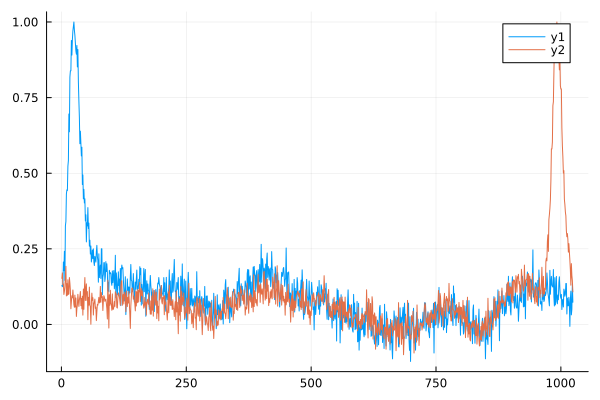

In [21]:
nchan = 2
inc_τ = true
inc_α = false
inc_EFAC = false
Nsamp = 0
#ar = load_data("/data/magnetar-1745-2858/SPs/20180716_45mm/transientX/SP_58315.8690312109_cfbf00000_01_01.ar", nchan, inc_τ, inc_α, inc_EFAC)
ar = load_data("/data/magnetar-1745-2858/rmsyn/NRT/data/nuppi_56460_1745-2858_178124.zap.E.zap", nchan, inc_τ, inc_α, inc_EFAC, Nsamp)



paramnames = ["beta", "phi0s"]
for i in 1:Nsamp
    paramnames = append!(paramnames, ["samp$i"])
end

if nchan > 1
    paramnames =  append!(paramnames, ["DM"])
end

if inc_τ
    paramnames =  append!(paramnames, ["Tau"])
end

if nchan > 1 && inc_τ && inc_α
    paramnames =  append!(paramnames, ["gamma"])
end

if inc_EFAC
    paramnames =  append!(paramnames, ["EFAC"])
end

println(paramnames, length(paramnames))


print(size(ar.data))
plot(ar.data)

#plot(ar.data[:,4])

#print(likelihood(ones(29,9)))


#sampler = ultranest.ReactiveNestedSampler(paramnames, likelihood, transform=mytransform, vectorized=true, derived_param_names=["Mc"], log_dir="ultranest")
#sampler.stepsampler = step.SliceSampler(
#        nsteps=3*length(paramnames),
#            generate_direction=step.generate_mixture_random_direction,
#    )
#@time results = sampler.run(viz_callback=false, show_status=false)

In [18]:
print(likelihood(ones(29,length(paramnames))))

[-7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18, -7.766279631452242e18]

In [80]:
nchan = 4
nbin = 16
F = zeros(nchan * nbin, 2*nchan)
A = ones(16)
profile = ones(16) * 5 
for ichan in 1:nchan
        F[1+(ichan-1)*nbin:ichan*nbin,(ichan-1)*2 + 1] = profile
        F[1+(ichan-1)*nbin:ichan*nbin,(ichan)*2] = A
end

In [27]:
#Shap_amp = [1]
#period = 5.52
#nbin = 2048
#β = 0.1
#rfft(shapelet_model(Shap_amp, period, nbin, β))

In [25]:
#factorial(19)

In [24]:
#model = ([0.04876018872861415 + 0.0im, 0.04753779348334358 + 0.0im, 0.04631468566673702 + 0.0im, 0.0450908939171889 + 0.0im, 0.04386644696898562 + 0.0im, 0.04264137365171916 + 0.0im, 0.041415702889696926 + 0.0im, 0.04018946370134613 + 0.0im, 0.03896268519861118 + 0.0im, 0.03773539658635183 + 0.0im, 0.03650762716172834 + 0.0im, 0.03527940631358911 + 0.0im, 0.03405076352184899 + 0.0im, 0.032821728356863256 + 0.0im, 0.03159233047879911 + 0.0im, 0.030362599636998805 + 0.0im, 0.029132565669339805 + 0.0im, 0.02790225850159056 + 0.0im, 0.02667170814676026 + 0.0im, 0.025440944704443275 + 0.0im, 0.024209998360160995 + 0.0im, 0.022978899384696133 + 0.0im, 0.021747678133423015 + 0.0im, 0.02051636504563517 + 0.0im, 0.019284990643864908 + 0.0im, 0.018053585533199412 + 0.0im, 0.016822180400593273 + 0.0im, 0.015590806014173342 + 0.0im, 0.014359493222541875 + 0.0im, 0.01312827295407304 + 0.0im, 0.011897176216205091 + 0.0im, 0.010666234094727667 + 0.0im, 0.009435477753065441 + 0.0im, 0.008204938431554232 + 0.0im, 0.00697464744671672 + 0.0im, 0.005744636190528729 + 0.0im, 0.004514936129684316 + 0.0im, 0.0032855788048553602 + 0.0im, 0.0020565958299453013 + 0.0im, 0.0008280188913386 + 0.0im, -0.000400120252852465 + 0.0im, -0.0016277897735490487 + 0.0im, -0.002854957771467881 + 0.0im, -0.004081592277891483 + 0.0im, -0.005307661255440077 + 0.0im, -0.006533132598850355 + 0.0im, -0.00775797413575674 + 0.0im, -0.008982153627479755 + 0.0im, -0.010205638769815534 + 0.0im, -0.01142839719383229 + 0.0im, -0.012650396466672237 + 0.0im, -0.013871604092353745 + 0.0im])
#real(model)

In [23]:
#plot(irfft(data2, 2048))